##### Using a genetic algorithm to search for relevant features in the compiled target dataframe

The sklearn.svm.NuSVR algorithm is a good performer with this data, and immediately returns a model with 95% R2 on the test set when fed all the features. The goal here is to find a minimal set of features that performs nearly as well, since not all algorithms are as tolerant of high dimensions, and maintaining feature sets is labor intensive. 

I find this preferable to Principle Component Analysis because PCA doesn't evaluate outlier target variables; it only shows vectors of movement within correlated inputs. This is useful but in a situation where mis-predicted outliers are dangerous, it may be better to find a subset of features that performs as well and just use those. 

Another reason to prefer this over PCA, if it works, is that it is much easier to continually collect data on a smaller number of features that matter than on a larger number of features that need to be fed into PCA.

## Uses https://pypi.org/project/sklearn-genetic/ 
Citation: Manuel Calzolari. (2021, April 3). manuel-calzolari/sklearn-genetic: sklearn-genetic 0.4.0 (Version 0.4.0). Zenodo. http://doi.org/10.5281/zenodo.4661178

Source code at https://github.com/manuel-calzolari/sklearn-genetic/blob/master/genetic_selection/gscv.py

NOTE:  DEAP, the library behind this library, mentions a different genetic option finding algorithm which is slightly newer: https://github.com/rodrigo-arenas/Sklearn-genetic-opt


## Additional setup reqired:
"conda install -c conda-forge sklearn-genetic"
or 
"pip install sklearn-genetic"

# Run time:  17 hours


## Why is this useful?

With 481 input parameters, to test every combination, that would be how many evaluations? 

per https://math.stackexchange.com/questions/563840/why-is-2n-the-maximum-number-of-subsets-of-a-set-of-size-n, 
2^N-1 is the number of discrete sets that can be made out of a set of N elements. 

2^481-1 is 6.243497e+144, or 6,243,497,100,631,984,462,763,
194,459,586,332,611,497,196,
285,329,942,301,718,313,919,
250,743,477,639,531,240,240,
612,206,126,983,942,319,653,
862,242,813,245,790,895,951,
358,576,570,612,580,351 evaluations.

So instead of evaluating 6.243497e+144 combinations, we'll use a genetic algorithm to randomly throw predictor variables in a set, make them fight, make the winners breed, and come up with strong contender algorithms on human timeframes. 

This can still take a long time depending on how many individual algorithms to evaluate.  Here, I chose to let it run a while, and evaluated N * 10 individuals with N * 0.66 parameters each for 80 generations using sklearn-genetic.

This is repeated 8 times, hopefully leaving me with 16 or so of my strongest performeing parameters, by removing the weakest third with each iteration.


In [1]:
# optional setup if running on Google Colab: 
# !pip install sklearn-genetic

In [2]:
# Import required libraries 

import pandas as pd 
import numpy as np 

### Load the predictors and target data to a pandas dataframe


In [3]:
# load from local CSV
#target_df = pd.read_csv("dataframes/target_df.csv.gz", compression="infer", parse_dates = ["opday"])

# Load from github
target_df = pd.read_csv("https://github.com/k5dru/CPSC_5383/blob/main/dataframes/target_df.csv.gz?raw=true", compression="gzip", parse_dates = ["opday"])


### View the source data

Always view the source data.  Pandas makes this trivial.

In [4]:
target_df.head()

,opday,sum_spp_load,is_Friday,is_Monday,is_Saturday,is_Sunday,is_Thursday,is_Tuesday,is_Wednesday,holiday_Christmas Day,...,HDD_TX_DALLAS_FT_WORTH_AP,HDD_TX_DALLAS_LOVE_FLD,HDD_TX_FT_WORTH_ALLIANCE_AP,HDD_TX_LUBBOCK,HDD_TX_MIDLAND_ODESSA,HDD_TX_SAN_ANGELO,HDD_TX_WACO_RGNL_AP,HDD_TX_WICHITA_FALLS_MUNI_AP,HDD_WY_CHEYENNE,HDD_WY_TORRINGTON_MUNI_AP
0,2015-10-03,566229.834662,0,0,1,0,0,0,0,0,...,0.0,0.0,1.05,5.28,0.00,0.0,0.0,3.30,18.24,16.98
1,2015-10-04,552166.723416,0,0,0,1,0,0,0,0,...,0.0,0.0,0.00,8.34,0.00,0.0,0.0,1.14,18.96,15.00
2,2015-10-05,596751.461994,0,1,0,0,0,0,0,0,...,0.0,0.0,0.00,7.44,1.14,0.0,0.0,1.14,12.30,7.08
3,2015-10-06,622735.355003,0,0,0,0,0,1,0,0,...,0.0,0.0,0.00,3.48,0.00,0.0,0.0,0.60,12.12,8.97
4,2015-10-07,645464.796588,0,0,0,0,0,0,1,0,...,0.0,0.0,0.00,0.00,0.00,0.0,0.0,0.00,7.44,0.51


In [5]:
target_df.describe()

,sum_spp_load,is_Friday,is_Monday,is_Saturday,is_Sunday,is_Thursday,is_Tuesday,is_Wednesday,holiday_Christmas Day,holiday_Christmas Eve,...,HDD_TX_DALLAS_FT_WORTH_AP,HDD_TX_DALLAS_LOVE_FLD,HDD_TX_FT_WORTH_ALLIANCE_AP,HDD_TX_LUBBOCK,HDD_TX_MIDLAND_ODESSA,HDD_TX_SAN_ANGELO,HDD_TX_WACO_RGNL_AP,HDD_TX_WICHITA_FALLS_MUNI_AP,HDD_WY_CHEYENNE,HDD_WY_TORRINGTON_MUNI_AP
count,1.535000e+03,1535.000000,1535.000000,1535.000000,1535.000000,1535.000000,1535.000000,1535.000000,1535.000000,1535.000000,...,1535.000000,1535.000000,1535.000000,1535.000000,1535.000000,1535.000000,1535.000000,1535.000000,1535.000000,1535.000000
mean,7.178639e+05,0.142671,0.143974,0.142671,0.143322,0.141368,0.142671,0.143322,0.003909,0.003257,...,5.443349,5.159023,6.173375,8.910704,6.428717,5.824339,5.486463,7.879974,19.121863,18.240430
std,1.007130e+05,0.349851,0.351178,0.349851,0.350516,0.348514,0.349851,0.350516,0.062418,0.056999,...,8.633520,8.407970,9.136330,11.073380,9.305757,8.850519,8.568441,10.596462,15.683710,16.434591
min,5.400074e+05,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,6.367939e+05,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.480000,0.000000
50%,6.941424e+05,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,2.760000,0.000000,0.000000,0.000000,0.960000,18.600000,16.890000
75%,7.862803e+05,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,9.060000,8.340000,10.995000,16.620000,11.760000,10.500000,9.420000,14.190000,30.660000,29.850000
max,1.016596e+06,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,42.000000,41.820000,44.970000,52.980000,46.860000,45.420000,44.520000,48.660000,69.540000,76.380000


In [6]:
target_df.columns


Index(['opday', 'sum_spp_load', 'is_Friday', 'is_Monday', 'is_Saturday',
       'is_Sunday', 'is_Thursday', 'is_Tuesday', 'is_Wednesday',
       'holiday_Christmas Day',
       ...
       'HDD_TX_DALLAS_FT_WORTH_AP', 'HDD_TX_DALLAS_LOVE_FLD',
       'HDD_TX_FT_WORTH_ALLIANCE_AP', 'HDD_TX_LUBBOCK',
       'HDD_TX_MIDLAND_ODESSA', 'HDD_TX_SAN_ANGELO', 'HDD_TX_WACO_RGNL_AP',
       'HDD_TX_WICHITA_FALLS_MUNI_AP', 'HDD_WY_CHEYENNE',
       'HDD_WY_TORRINGTON_MUNI_AP'],
      dtype='object', length=483)

## Selection of the predictor measures

and convert the predictors and target to a numpy matrix and vector respectively



In [7]:
# One of the goals of dimension reduction is to reduce the amount of work it takes 
# to gather the data. 
# I am very interested in which airports are most effective 

# try everything first: 
predictors_df = target_df.drop(['opday', 'sum_spp_load'], axis=1).copy()


In [8]:
# try "months since 2015"; this should work as well as opday if it is only modeling load growth over time 
# predictors_df['opmonth'] = (target_df.opday.dt.year - 2015) * 12 + target_df.opday.dt.month 

In [9]:
from sklearn import metrics

# use all the continuous regression metrics from 
# https://scikit-learn.org/stable/modules/model_evaluation.html#regression-metrics

report=pd.DataFrame(columns=['Algorithm', 'Explained Variance', 'R2/COD', 'Max Error', 'Mean AE', 
                             'Mean Squared Error', 'MAPE',
                             'Median AE'])

def add_to_report(rep, algorithm, y_test, y_pred):
    explained_variance = metrics.explained_variance_score(y_test, y_pred)
    r2_score = metrics.r2_score(y_test, y_pred)
    max_error = metrics.max_error(y_test, y_pred)
    mean_absolute_error = metrics.mean_absolute_error(y_test, y_pred)
    mean_squared_error = metrics.mean_squared_error(y_test, y_pred)
#    mean_squared_log_error = metrics.mean_squared_log_error(y_test, y_pred)
#    Mean Squared Logarithmic Error cannot be used when targets contain negative values.
    mean_absolute_percentage_error = metrics.mean_absolute_percentage_error(y_test, y_pred)
    median_absolute_error = metrics.median_absolute_error(y_test, y_pred)
    rep.loc[len(rep.index)] = [algorithm, explained_variance, r2_score, max_error, mean_absolute_error,
                              mean_squared_error, mean_absolute_percentage_error,
                              median_absolute_error]
    return rep

In [10]:
# scatter plot true vs. predicted values 
import pylab as pl
%matplotlib inline
from pylab import *

def myplot (algorithm, x_axis, y_axis):
    pl.figure(figsize=(8, 6), dpi=120)
    pl.scatter(x_axis, x_axis,  c="y", label='true', s=1)
    pl.scatter(x_axis, y_axis,  c="b", label=algorithm, s=1)
    pl.legend()
    plt.xlabel("True Demand")  # custom x label using matplotlib
    plt.ylabel("Predicted Demand")
    pl.show()

# Set up a function to winnow down the features by some percent


In [11]:
# using datetime module
import datetime;
  
# ct stores current time
ct = datetime.datetime.now()
print("current time:-", ct)

current time:- 2021-11-22 22:35:39.622208


In [12]:
# call as winnow_predictors(predictors_df, target_df['sum_spp_load'])
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import NuSVR
from genetic_selection import GeneticSelectionCV

def winnow_predictors(X_df, y_vec):
    
    num_features = len(X_df.columns)
    
    predictor_names = predictors_df.columns.to_numpy()
    predictors = predictors_df.to_numpy()

    # convert to Numpy arrays
    predictor_names = X_df.columns.to_numpy()
    predictors = X_df.to_numpy()
    target = y_vec.to_numpy()
    
    # scale the predictors
    scaler = MinMaxScaler((0, 1))
    X = scaler.fit_transform(predictors)
    y = scaler.fit_transform(target.reshape(-1, 1)).ravel()
    
    # split into test/train, without shuffling because we want to be able to evaluate NEW time series data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .237, shuffle=False)
    
    # use a good performing (and fast!) algorithm as the estimator
    estimator = NuSVR(C=3.0, nu=0.1, verbose=False)
    
    ct = datetime.datetime.now()
    print (f"Starting with {num_features} features at {ct}")
    
    selector = GeneticSelectionCV(estimator,
                                  verbose=1,
                                  max_features=int(num_features * 0.66), # percent to winnow down to
                                  n_population=num_features * 10, # was 500
                                  n_jobs=4,           # local cpu has 4 cores, 8 threads
                                  n_generations=80  # was 80
                                 )
                                  
    selector = selector.fit(X_train, y_train)
    
    # return winnowed set 
    rdf = X_df[X_df.columns[selector.support_]].copy()
    
    ct = datetime.datetime.now()
    print (f"Sending back {len(rdf.columns)} features at {ct}")
    
    return rdf


In [13]:
def plot_and_report(X_df, y_vec, rep): 
    model_desc = 'sklearn.svm.NuSVR ' + str(len(X_df.columns)) + ' features'
    
    # convert to Numpy arrays
    predictor_names = X_df.columns.to_numpy()
    predictors = X_df.to_numpy()
    target = y_vec.to_numpy()
    
    # scale the predictors
    scaler = MinMaxScaler((0, 1))
    X = scaler.fit_transform(predictors)
    y = scaler.fit_transform(target.reshape(-1, 1)).ravel()
    
    # split into test/train, without shuffling because we want to be able to evaluate NEW time series data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .237, shuffle=False)

    # run NuSVR regression
    regr = NuSVR(C=3.0, nu=0.1, verbose=False ) #originally C=1.0, nu=1.0
    regr.fit(X_train, y_train)

    y_pred = regr.predict(X_test)

    # show results
    myplot(model_desc, y_test, y_pred)

    # save results for report
    rep = add_to_report(rep, model_desc, y_test, y_pred)
    rep.tail(1)

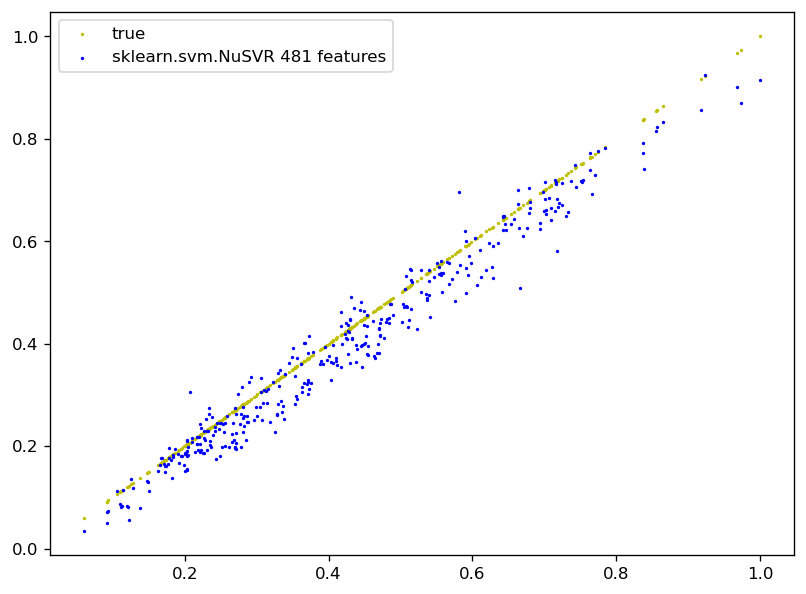

,Algorithm,Explained Variance,R2/COD,Max Error,Mean AE,Mean Squared Error,MAPE,Median AE
0,sklearn.svm.NuSVR 481 features,0.969399,0.951331,0.155966,0.034574,0.001887,0.096031,0.030218


In [14]:
plot_and_report(predictors_df, target_df['sum_spp_load'], report)
report.tail(1)

Starting with 481 features at 2021-11-22 22:35:40.047225
Selecting features with genetic algorithm.
gen	nevals	avg                        	std                            	min                      	max                        
0  	4810  	[  0.86092849 157.24033264]	[7.28138632e-02 9.21689064e+01]	[-0.42473263  1.        ]	[  0.93727789 317.        ]
1  	2824  	[ -3.26075171 220.5       ]	[203.88775123  66.51877715]    	[-10000.     13.]        	[  0.93727789 325.        ]
2  	2843  	[-13.63675299 250.36340956]	[381.24142678  48.43419944]    	[-10000.     54.]        	[  0.93727789 326.        ]
3  	2900  	[-11.54843441 267.19417879]	[352.99804     33.95187568]    	[-10000.     91.]        	[  0.93746508 324.        ]
4  	2908  	[-15.70350209 274.66652807]	[407.52230609  26.65358394]    	[-10000.    113.]        	[  0.9377509 321.       ]  
5  	2890  	[-21.93940153 277.28711019]	[477.71304941  24.69642925]    	[-10000.    130.]        	[  0.93845328 322.        ]
6  	2903  	[ -1.14622569 

63 	2978  	[  0.95271791 226.51580042]	[0.00711425 6.11078082]        	[  0.88009442 205.        ]	[  0.95541177 254.        ]
64 	2832  	[  0.95276531 225.46756757]	[0.00731938 6.07221682]        	[  0.8832422 204.       ]  	[  0.95568383 251.        ]
65 	2927  	[  0.95294613 224.58378378]	[0.00715756 5.99526381]        	[  0.8741005 202.       ]  	[  0.95586666 249.        ]
66 	2865  	[  0.95328281 223.56777547]	[0.00651288 5.91418896]        	[  0.88706069 204.        ]	[  0.9559776 248.       ]  
67 	2830  	[  0.9534324  222.67525988]	[0.00690182 5.86750373]        	[  0.87199276 203.        ]	[  0.95615145 251.        ]
68 	2861  	[  0.95354347 221.77089397]	[0.00704007 5.90763144]        	[  0.88146556 202.        ]	[  0.95635337 244.        ]
69 	2880  	[  0.9536989  220.79459459]	[0.00689753 5.79247952]        	[  0.88437825 203.        ]	[  0.95644747 243.        ]
70 	2944  	[  0.95374093 219.75738046]	[0.00731671 5.80425435]        	[  0.88145348 198.        ]	[  0.9564706

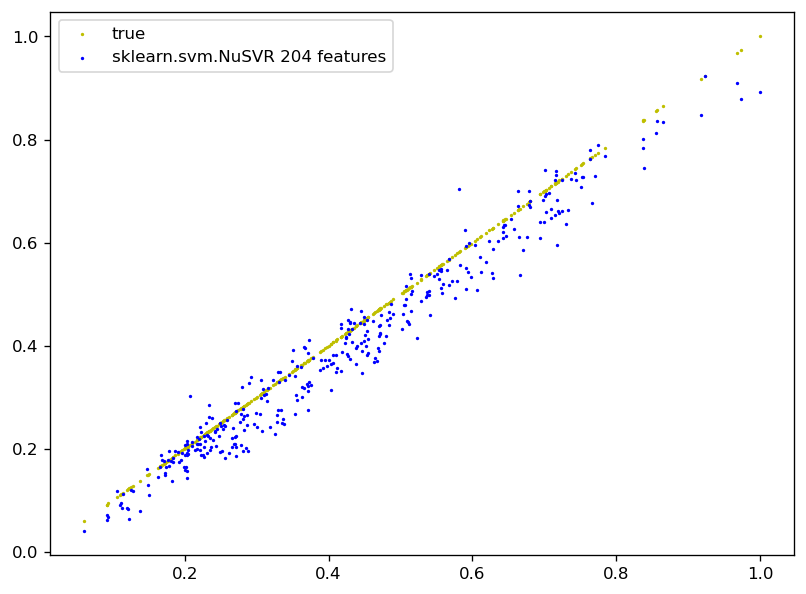

,Algorithm,Explained Variance,R2/COD,Max Error,Mean AE,Mean Squared Error,MAPE,Median AE
1,sklearn.svm.NuSVR 204 features,0.96841,0.948868,0.12788,0.035083,0.001983,0.096314,0.029405


In [15]:
model_desc = 'sklearn.svm.NuSVR ' + str(len(predictors_df.columns)) + ' features'
new_predictors_df = winnow_predictors(predictors_df, target_df['sum_spp_load'])
predictors_df = new_predictors_df
plot_and_report(predictors_df, target_df['sum_spp_load'], report)
report.tail(1)

In [16]:
predictors_df.columns.values

array(['is_Monday', 'is_Saturday', 'is_Sunday', 'is_Thursday',
       'is_Wednesday', 'holiday_Day After Thanksgiving',
       'holiday_Labor Day', 'holiday_Thanksgiving', 'is_holiday',
       'TMIN_AR_FT_SMITH_RGNL_AP', 'TMIN_AR_HARRISON_BOONE_CO_AP',
       'TMIN_AR_LITTLE_ROCK', 'TMIN_AR_LITTLE_ROCK_AP_ADAMS_FLD',
       'TMIN_AR_MOUNT_IDA_ASOS', 'TMIN_CO_ALAMOSA_SAN_LUIS_AP',
       'TMIN_CO_COLORADO_SPRINGS_MUNI_AP', 'TMIN_CO_DENVER_INTL_AP',
       'TMIN_CO_PUEBLO_MEM_AP', 'TMIN_IA_AMES_MUNI_AP', 'TMIN_KS_ANTHONY',
       'TMIN_KS_CONCORDIA_MUNI_AP', 'TMIN_KS_DODGE_CITY',
       'TMIN_KS_HILL_CITY_MUNI_AP', 'TMIN_KS_WICHITA',
       'TMIN_LA_SHREVEPORT', 'TMIN_MN_DULUTH',
       'TMIN_MN_INTL_FALLS_INTL_AP', 'TMIN_MN_ST_CLOUD_RGNL_AP',
       'TMIN_MN_ST_PAUL_DOWNTOWN_AP', 'TMIN_MO_SPRINGFIELD',
       'TMIN_MT_BAKER_MUNI_AP', 'TMIN_MT_MILES_CITY_F_WILEY_FLD',
       'TMIN_ND_BISMARCK', 'TMIN_ND_HETTINGER_MUNI_AP',
       'TMIN_ND_JAMESTOWN_MUNI_AP', 'TMIN_NE_BROKEN_BOW_MUNI_AP',

Starting with 204 features at 2021-11-23 08:07:16.661921
Selecting features with genetic algorithm.
gen	nevals	avg                      	std                      	min                  	max                        
0  	2040  	[ 0.85925241 67.0254902 ]	[ 0.0825458  38.55638012]	[0.0540358 1.       ]	[  0.95069716 134.        ]
1  	1251  	[-28.5098348   93.57058824]	[541.57700566  26.88648829]	[-1.e+04  9.e+00]    	[  0.95069716 136.        ]
2  	1284  	[-33.38876942 105.2245098 ]	[584.82758464  20.06955033]	[-10000.     29.]    	[  0.9508086 140.       ]  
3  	1238  	[-23.57230224 114.57892157]	[494.51316154  13.52364113]	[-10000.     52.]    	[  0.95152456 136.        ]
4  	1251  	[-82.39686482 121.02990196]	[909.14518885   8.17921733]	[-10000.     87.]    	[  0.95285491 140.        ]
5  	1183  	[-102.00433209  123.3627451 ]	[1009.45914618    6.21547597]	[-10000.     98.]    	[  0.95374622 139.        ]
6  	1233  	[-121.61279935  123.99901961]	[1100.31877679    5.90089716]	[-10000.     9

66 	1201  	[-23.55368068 127.75294118]  	[494.51408457   2.7419653 ]  	[-10000.    114.]          	[  0.96061674 137.        ]
67 	1214  	[-33.35850483 128.00098039]  	[584.82936034   2.67852736]  	[-10000.    116.]          	[  0.96064898 138.        ]
68 	1184  	[-28.45601714 128.22892157]  	[541.57992796   2.59676398]  	[-10000.    113.]          	[  0.96065275 138.        ]
69 	1227  	[ -8.84629211 128.34558824]  	[312.98862092   2.55521001]  	[-10000.    115.]          	[  0.96066761 136.        ]
70 	1236  	[ -3.94365913 128.48186275]  	[221.37067162   2.33466302]  	[-10000.    115.]          	[  0.96073085 135.        ]
71 	1179  	[ -8.8457551 128.5877451]    	[312.98863771   2.2524816 ]  	[-10000.    113.]          	[  0.96079261 135.        ]
72 	1258  	[-13.74843289 128.31519608]  	[383.23716188   2.47163605]  	[-10000.    116.]          	[  0.9608003 135.       ]  
73 	1225  	[-23.55336701 128.09166667]  	[494.51410011   2.3668315 ]  	[-10000.    115.]          	[  0.9608624

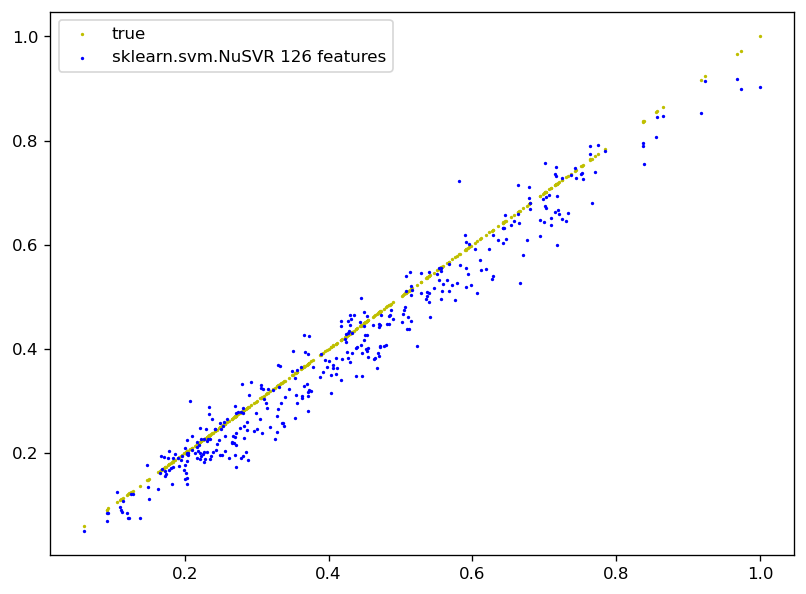

,Algorithm,Explained Variance,R2/COD,Max Error,Mean AE,Mean Squared Error,MAPE,Median AE
2,sklearn.svm.NuSVR 126 features,0.964251,0.948085,0.140659,0.035539,0.002013,0.097616,0.030423


In [17]:
model_desc = 'sklearn.svm.NuSVR ' + str(len(predictors_df.columns)) + ' features'
new_predictors_df = winnow_predictors(predictors_df, target_df['sum_spp_load'])
predictors_df = new_predictors_df
plot_and_report(predictors_df, target_df['sum_spp_load'], report)
report.tail(1)

In [18]:
predictors_df.columns.values

array(['is_Monday', 'is_Saturday', 'is_Sunday', 'is_Thursday',
       'holiday_Labor Day', 'is_holiday', 'TMIN_AR_FT_SMITH_RGNL_AP',
       'TMIN_AR_LITTLE_ROCK_AP_ADAMS_FLD', 'TMIN_AR_MOUNT_IDA_ASOS',
       'TMIN_CO_ALAMOSA_SAN_LUIS_AP', 'TMIN_CO_COLORADO_SPRINGS_MUNI_AP',
       'TMIN_CO_DENVER_INTL_AP', 'TMIN_IA_AMES_MUNI_AP',
       'TMIN_KS_ANTHONY', 'TMIN_KS_DODGE_CITY', 'TMIN_MN_DULUTH',
       'TMIN_MN_ST_CLOUD_RGNL_AP', 'TMIN_MN_ST_PAUL_DOWNTOWN_AP',
       'TMIN_MO_SPRINGFIELD', 'TMIN_MT_BAKER_MUNI_AP',
       'TMIN_MT_MILES_CITY_F_WILEY_FLD', 'TMIN_ND_BISMARCK',
       'TMIN_ND_JAMESTOWN_MUNI_AP', 'TMIN_NE_BROKEN_BOW_MUNI_AP',
       'TMIN_NE_IMPERIAL_MUNI_AP', 'TMIN_NE_LINCOLN_MUNI_AP',
       'TMIN_NE_NORTH_PLATTE_RGNL_AP', 'TMIN_NE_VALENTINE_MILLER_FLD',
       'TMIN_OK_OKLAHOMA_CITY_WILL_ROGERS_AP', 'TMIN_SD_ABERDEEN',
       'TMIN_SD_WATERTOWN_RGNL_AP', 'TMIN_TX_ABILENE_RGNL_AP',
       'TMIN_TX_LUBBOCK', 'TMIN_TX_WACO_RGNL_AP',
       'TMAX_AR_MOUNTAIN_HOME_BAXTER_AP'

Starting with 126 features at 2021-11-23 11:00:59.700657
Selecting features with genetic algorithm.
gen	nevals	avg                      	std                      	min                      	max                      
0  	1260  	[ 0.84006894 41.8952381 ]	[ 0.1254724  23.88949712]	[-1.04202437  1.        ]	[ 0.94897939 83.        ]
1  	735   	[-46.72693015  58.95873016]	[688.48229519  16.79285217]	[-10000.     14.]        	[ 0.94988304 87.        ]
2  	733   	[-78.45125611  66.02777778]	[887.4102976   12.71731814]	[-10000.     21.]        	[ 0.95097568 88.        ]
3  	774   	[-141.93411019   72.08888889]	[1186.77167199    8.4553939 ]	[-10000.     32.]        	[ 0.95173999 89.        ]
4  	761   	[-308.60979504   75.92539683]	[1732.05050498    5.56854739]	[-10000.     45.]        	[ 0.95277708 87.        ]
5  	751   	[-411.79171988   77.9484127 ]	[1989.32465022    4.07758554]	[-10000.     65.]        	[ 0.95277708 90.        ]
6  	735   	[-380.04106602   78.51587302]	[1914.44338153    3.63

65 	748   	[-229.22206019   82.5484127 ]	[1.49968178e+03 1.38702801e+00]	[-10000.     74.]        	[ 0.96071041 87.        ]
66 	700   	[-308.59475345   82.53333333]	[1.73205319e+03 1.41746476e+00]	[-10000.     70.]        	[ 0.96071041 89.        ]
67 	760   	[-316.53216408   82.35952381]	[1.75339997e+03 1.51817970e+00]	[-10000.     74.]        	[ 0.96071041 88.        ]
68 	745   	[-268.90852526   82.24047619]	[1.62052516e+03 1.47307467e+00]	[-10000.     74.]        	[ 0.96071041 87.        ]
69 	750   	[-268.90860551   81.91111111]	[1.62052515e+03 1.53737677e+00]	[-10000.     73.]        	[ 0.96089831 87.        ]
70 	710   	[-102.22560235   81.53015873]	[1010.59233523    1.59360178]  	[-10000.     70.]        	[ 0.96089831 88.        ]
71 	757   	[-173.66120414   81.43730159]	[1309.9139038     1.54869295]  	[-10000.     73.]        	[ 0.96089999 89.        ]
72 	759   	[-189.53544605   81.44603175]	[1367.05490808    1.54645785]  	[-10000.     72.]        	[ 0.96089999 87.        ]


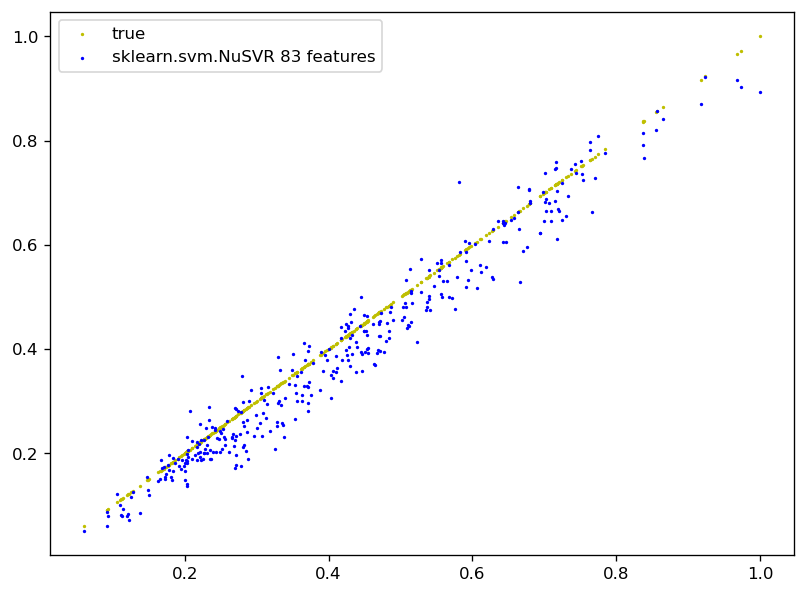

,Algorithm,Explained Variance,R2/COD,Max Error,Mean AE,Mean Squared Error,MAPE,Median AE
3,sklearn.svm.NuSVR 83 features,0.96479,0.9478,0.139715,0.035646,0.002024,0.098877,0.030003


In [19]:
model_desc = 'sklearn.svm.NuSVR ' + str(len(predictors_df.columns)) + ' features'
new_predictors_df = winnow_predictors(predictors_df, target_df['sum_spp_load'])
predictors_df = new_predictors_df
plot_and_report(predictors_df, target_df['sum_spp_load'], report)
report.tail(1)

In [20]:
predictors_df.columns.values

array(['is_Monday', 'is_Saturday', 'is_Sunday', 'holiday_Labor Day',
       'is_holiday', 'TMIN_AR_FT_SMITH_RGNL_AP',
       'TMIN_CO_ALAMOSA_SAN_LUIS_AP', 'TMIN_CO_COLORADO_SPRINGS_MUNI_AP',
       'TMIN_CO_DENVER_INTL_AP', 'TMIN_IA_AMES_MUNI_AP',
       'TMIN_KS_ANTHONY', 'TMIN_KS_DODGE_CITY', 'TMIN_MN_DULUTH',
       'TMIN_MO_SPRINGFIELD', 'TMIN_MT_BAKER_MUNI_AP',
       'TMIN_MT_MILES_CITY_F_WILEY_FLD', 'TMIN_ND_BISMARCK',
       'TMIN_NE_IMPERIAL_MUNI_AP', 'TMIN_NE_LINCOLN_MUNI_AP',
       'TMIN_NE_NORTH_PLATTE_RGNL_AP', 'TMIN_NE_VALENTINE_MILLER_FLD',
       'TMIN_SD_ABERDEEN', 'TMIN_TX_LUBBOCK',
       'TMAX_AR_MOUNTAIN_HOME_BAXTER_AP', 'TMAX_CO_DENVER_CENTENNIAL_AP',
       'TMAX_IA_ESTHERVILLE_MUNI_AP', 'TMAX_KS_DODGE_CITY',
       'TMAX_KS_HILL_CITY_MUNI_AP', 'TMAX_KS_WICHITA',
       'TMAX_MO_KANSAS_CITY_INTL_AP', 'TMAX_MT_MILES_CITY_F_WILEY_FLD',
       'TMAX_ND_MINOT_INTL_AP', 'TMAX_NE_CHADRON_MUNI_AP',
       'TMAX_NE_NORTH_PLATTE_RGNL_AP', 'TMAX_NM_CLAYTON_MUNI_AIR_PK',


Starting with 83 features at 2021-11-23 12:30:36.135346
Selecting features with genetic algorithm.
gen	nevals	avg                      	std                      	min                      	max                    
0  	830   	[ 0.82139568 28.00361446]	[ 0.13862035 15.62979041]	[-0.25664821  1.        ]	[ 0.9461742 54.       ]
1  	505   	[-47.30543603  39.13493976]	[692.59706818  10.62033097]	[-1.e+04  6.e+00]        	[ 0.94798908 58.        ]
2  	495   	[-191.87115279   44.39638554]	[1375.09895292    7.4060045 ]	[-10000.     12.]        	[ 0.94798908 57.        ]
3  	468   	[-119.56140173   47.07710843]	[1091.11191275    5.06096151]	[-10000.     27.]        	[ 0.94865242 57.        ]
4  	516   	[-215.94914466   48.98554217]	[1456.72287269    3.55910956]	[-10000.     33.]        	[ 0.94919492 58.        ]
5  	480   	[-324.38972664   49.55662651]	[1774.19959762    3.2006849 ]	[-10000.     40.]        	[ 0.95008057 59.        ]
6  	473   	[-360.53681003   49.81325301]	[1866.67402008    3.282

64 	527   	[-444.86890894   53.78915663]  	[2.06395830e+03 9.84275411e-01]	[-10000.     47.]        	[ 0.95841328 58.        ]
65 	499   	[-360.52347187   53.77831325]  	[1.86667660e+03 9.25677634e-01]	[-10000.     48.]        	[ 0.95841328 57.        ]
66 	498   	[-252.07999867   53.70120482]  	[1.57053400e+03 1.07091831e+00]	[-10000.     46.]        	[ 0.95841328 59.        ]
67 	506   	[-456.91860799   53.75783133]  	[2.09034435e+03 1.06777784e+00]	[-10000.     46.]        	[ 0.95841328 60.        ]
68 	507   	[-360.52360091   53.75060241]  	[1.86667658e+03 9.38708866e-01]	[-10000.     47.]        	[ 0.95841328 57.        ]
69 	514   	[-372.5726346    53.72409639]  	[1.89634656e+03 1.01661977e+00]	[-10000.     46.]        	[ 0.95841328 58.        ]
70 	467   	[-288.2273929    53.76385542]  	[1.67585564e+03 9.86484364e-01]	[-10000.     46.]        	[ 0.95841328 58.        ]
71 	482   	[-432.81997477   53.76144578]  	[2.03715909e+03 1.07813218e+00]	[-10000.     47.]        	[ 0.958413

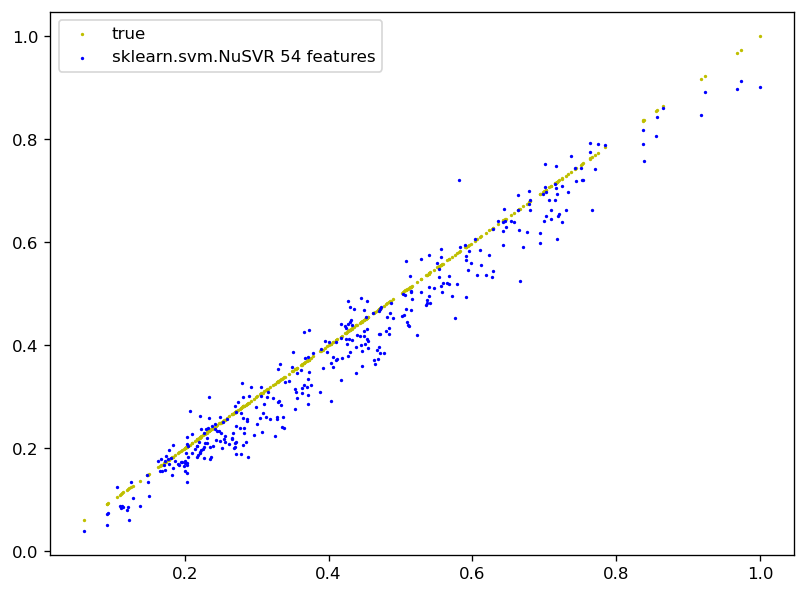

,Algorithm,Explained Variance,R2/COD,Max Error,Mean AE,Mean Squared Error,MAPE,Median AE
4,sklearn.svm.NuSVR 54 features,0.964661,0.946521,0.141138,0.036321,0.002074,0.10202,0.03081


In [21]:
model_desc = 'sklearn.svm.NuSVR ' + str(len(predictors_df.columns)) + ' features'
new_predictors_df = winnow_predictors(predictors_df, target_df['sum_spp_load'])
predictors_df = new_predictors_df
plot_and_report(predictors_df, target_df['sum_spp_load'], report)
report.tail(1)

In [22]:
predictors_df.columns.values

array(['is_Monday', 'is_Saturday', 'is_Sunday', 'is_holiday',
       'TMIN_AR_FT_SMITH_RGNL_AP', 'TMIN_CO_ALAMOSA_SAN_LUIS_AP',
       'TMIN_CO_COLORADO_SPRINGS_MUNI_AP', 'TMIN_KS_DODGE_CITY',
       'TMIN_MN_DULUTH', 'TMIN_MT_BAKER_MUNI_AP',
       'TMIN_MT_MILES_CITY_F_WILEY_FLD', 'TMIN_ND_BISMARCK',
       'TMIN_NE_IMPERIAL_MUNI_AP', 'TMIN_NE_LINCOLN_MUNI_AP',
       'TMIN_NE_VALENTINE_MILLER_FLD', 'TMIN_SD_ABERDEEN',
       'TMAX_AR_MOUNTAIN_HOME_BAXTER_AP', 'TMAX_CO_DENVER_CENTENNIAL_AP',
       'TMAX_IA_ESTHERVILLE_MUNI_AP', 'TMAX_KS_DODGE_CITY',
       'TMAX_KS_HILL_CITY_MUNI_AP', 'TMAX_KS_WICHITA',
       'TMAX_MO_KANSAS_CITY_INTL_AP', 'TMAX_MT_MILES_CITY_F_WILEY_FLD',
       'TMAX_ND_MINOT_INTL_AP', 'TMAX_NE_NORTH_PLATTE_RGNL_AP',
       'TMAX_OK_LAWTON_MUNI_AP', 'TMAX_OK_OKLAHOMA_CITY_WILL_ROGERS_AP',
       'TMAX_SD_HURON_RGNL_AP', 'TMAX_SD_WATERTOWN_RGNL_AP',
       'TAVG_CO_DENVER_INTL_AP', 'TAVG_IA_DES_MOINES_INTL_AP',
       'TAVG_ND_FARGO_HECTOR_INTL_AP', 'CDD_AR_FT_SMI

Starting with 54 features at 2021-11-23 13:23:08.624171
Selecting features with genetic algorithm.
gen	nevals	avg                      	std                    	min                      	max                      
0  	540   	[ 0.78208358 17.91851852]	[0.19068202 9.89242273]	[-1.05806583  1.        ]	[ 0.94352086 35.        ]
1  	315   	[-91.71882368  26.71481481]	[957.86969636   6.24945649]	[-1.e+04  6.e+00]        	[ 0.94352086 37.        ]
2  	290   	[-54.65217701  29.42222222]	[743.35019763   4.04825828]	[-10000.     12.]        	[ 0.94360481 37.        ]
3  	342   	[-462.08059728   31.32592593]	[2101.45472657    3.11526618]	[-10000.     19.]        	[ 0.94394465 40.        ]
4  	336   	[-350.95168971   32.27592593]	[1842.6481677     2.23519286]	[-10000.     24.]        	[ 0.94462009 38.        ]
5  	303   	[-462.06928543   32.83518519]	[2.10145722e+03 1.91211124e+00]	[-10000.     26.]        	[ 0.94699647 40.        ]
6  	295   	[-425.02630656   33.06481481]	[2.01955756e+03 1.6514480

65 	328   	[-517.61766431   34.84814815]	[2.21748912e+03 8.55860135e-01]	[-10000.     30.]        	[ 0.95240909 38.        ]
66 	339   	[-517.61795667   34.81111111]	[2.21748905e+03 8.61451546e-01]	[-10000.     28.]        	[ 0.95240909 37.        ]
67 	311   	[-387.97624322   34.81481481]	[1.93348499e+03 8.29414655e-01]	[-10000.     31.]        	[ 0.95240909 38.        ]
68 	340   	[-387.97603422   34.82037037]	[1.93348503e+03 8.25043126e-01]	[-10000.     30.]        	[ 0.95240909 39.        ]
69 	332   	[-462.05657338   34.83148148]	[2.10146002e+03 7.62142223e-01]	[-10000.     31.]        	[ 0.95240909 40.        ]
70 	317   	[-610.22009332   34.76851852]	[2.39556745e+03 9.77586612e-01]	[-10000.     29.]        	[ 0.95240909 38.        ]
71 	326   	[-591.6987071    34.87962963]	[2.36131731e+03 6.87421276e-01]	[-10000.     30.]        	[ 0.95240909 38.        ]
72 	300   	[-702.82008292   34.85925926]	[2.55794484e+03 8.20234501e-01]	[-10000.     30.]        	[ 0.95240909 38.        ]


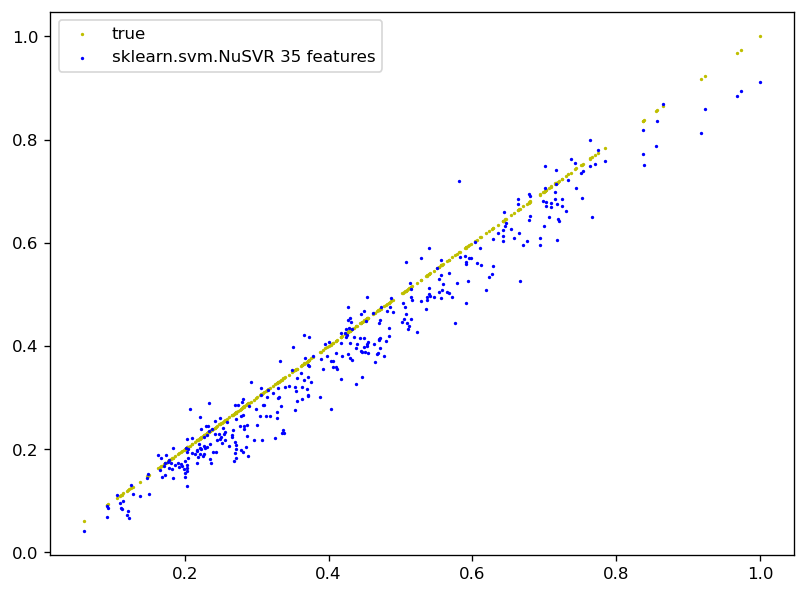

,Algorithm,Explained Variance,R2/COD,Max Error,Mean AE,Mean Squared Error,MAPE,Median AE
5,sklearn.svm.NuSVR 35 features,0.964451,0.940452,0.140284,0.038503,0.002309,0.104472,0.031218


In [23]:
model_desc = 'sklearn.svm.NuSVR ' + str(len(predictors_df.columns)) + ' features'
new_predictors_df = winnow_predictors(predictors_df, target_df['sum_spp_load'])
predictors_df = new_predictors_df
plot_and_report(predictors_df, target_df['sum_spp_load'], report)
report.tail(1)

In [24]:
predictors_df.columns.values

array(['is_Monday', 'is_Saturday', 'is_Sunday', 'is_holiday',
       'TMIN_AR_FT_SMITH_RGNL_AP', 'TMIN_CO_ALAMOSA_SAN_LUIS_AP',
       'TMIN_MN_DULUTH', 'TMIN_MT_MILES_CITY_F_WILEY_FLD',
       'TMIN_ND_BISMARCK', 'TMIN_NE_LINCOLN_MUNI_AP',
       'TMIN_NE_VALENTINE_MILLER_FLD', 'TMIN_SD_ABERDEEN',
       'TMAX_AR_MOUNTAIN_HOME_BAXTER_AP', 'TMAX_KS_DODGE_CITY',
       'TMAX_KS_HILL_CITY_MUNI_AP', 'TMAX_MT_MILES_CITY_F_WILEY_FLD',
       'TMAX_NE_NORTH_PLATTE_RGNL_AP',
       'TMAX_OK_OKLAHOMA_CITY_WILL_ROGERS_AP',
       'TMAX_SD_WATERTOWN_RGNL_AP', 'TAVG_CO_DENVER_INTL_AP',
       'TAVG_IA_DES_MOINES_INTL_AP', 'TAVG_ND_FARGO_HECTOR_INTL_AP',
       'CDD_KS_ANTHONY', 'CDD_MO_KANSAS_CITY_INTL_AP',
       'CDD_MO_SPRINGFIELD', 'CDD_NM_CLAYTON_MUNI_AIR_PK',
       'CDD_NM_ROSWELL_IND_AIR_PK', 'CDD_OK_TULSA_INTL_AP',
       'CDD_SD_SIOUX_FALLS', 'CDD_TX_DALLAS_LOVE_FLD',
       'HDD_LA_SHREVEPORT', 'HDD_ND_THEODORE_ROOSEVELT_AP',
       'HDD_OK_OKLAHOMA_CITY_WILL_ROGERS_AP', 'HDD_TX_AMARIL

Starting with 35 features at 2021-11-23 13:52:44.977706
Selecting features with genetic algorithm.
gen	nevals	avg                      	std                    	min                      	max                      
0  	350   	[ 0.73276909 11.34857143]	[0.25476552 6.41014247]	[-1.05806583  1.        ]	[ 0.93105405 23.        ]
1  	189   	[-142.01002551   16.41142857]	[1186.76253362    4.83521437]	[-1.e+04  4.e+00]        	[ 0.93105405 27.        ]
2  	201   	[-84.83093046  19.38285714]  	[921.92589625   3.26045446]  	[-1.e+04  8.e+00]        	[ 0.93275055 25.        ]
3  	206   	[-656.29315217   21.01142857]	[2.47804533e+03 2.25512387e+00]	[-10000.     13.]        	[ 0.9331298 26.       ]  
4  	185   	[-656.28247636   21.84285714]	[2.47804816e+03 1.47779483e+00]	[-10000.     13.]        	[ 0.93443259 25.        ]
5  	177   	[-884.87060692   22.16857143]	[2.84150447e+03 1.35546965e+00]	[-10000.     16.]        	[ 0.93538318 27.        ]
6  	215   	[-970.59146238   22.14857143]	[2.96179653e+

64 	218   	[-427.66817561   22.9       ]  	[2.02554069e+03 7.00000000e-01]	[-10000.     19.]        	[ 0.94604718 27.        ]
65 	202   	[-484.81570205   22.92857143]  	[2.14990638e+03 6.02884224e-01]	[-10000.     19.]        	[ 0.94604718 26.        ]
66 	197   	[-313.37125065   22.88571429]  	[1.74489440e+03 5.54020555e-01]	[-10000.     19.]        	[ 0.94604718 25.        ]
67 	215   	[-313.3712463    22.87428571]  	[1.74489440e+03 5.86682127e-01]	[-10000.     20.]        	[ 0.94604718 25.        ]
68 	215   	[-256.22329542   22.87714286]  	[1.58296528e+03 5.59890660e-01]	[-10000.     19.]        	[ 0.94604718 25.        ]
69 	222   	[-456.2423316   22.88     ]    	[2.08884474e+03 6.94796990e-01]	[-10000.     18.]        	[ 0.94604718 26.        ]
70 	204   	[-284.79675508   22.92285714]  	[1.66614361e+03 5.15245137e-01]	[-10000.     20.]        	[ 0.94604718 25.        ]
71 	232   	[-227.64928658   22.85428571]  	[1.49462067e+03 5.69632893e-01]	[-10000.     19.]        	[ 0.946146

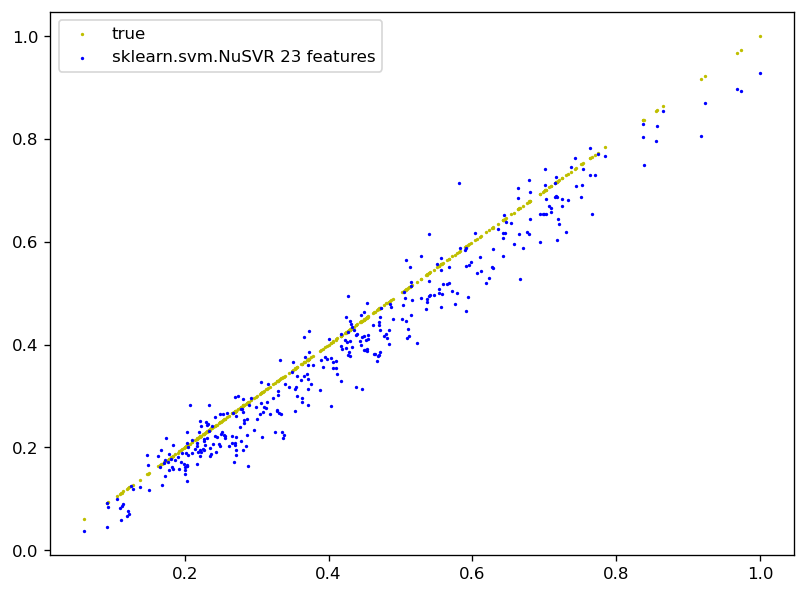

,Algorithm,Explained Variance,R2/COD,Max Error,Mean AE,Mean Squared Error,MAPE,Median AE
6,sklearn.svm.NuSVR 23 features,0.961158,0.935268,0.137628,0.04057,0.00251,0.111065,0.036628


In [25]:
model_desc = 'sklearn.svm.NuSVR ' + str(len(predictors_df.columns)) + ' features'
new_predictors_df = winnow_predictors(predictors_df, target_df['sum_spp_load'])
predictors_df = new_predictors_df
plot_and_report(predictors_df, target_df['sum_spp_load'], report)
report.tail(1)

In [26]:
predictors_df.columns.values

array(['is_Monday', 'is_Saturday', 'is_Sunday', 'is_holiday',
       'TMIN_AR_FT_SMITH_RGNL_AP', 'TMIN_CO_ALAMOSA_SAN_LUIS_AP',
       'TMIN_MN_DULUTH', 'TMIN_NE_LINCOLN_MUNI_AP',
       'TMIN_NE_VALENTINE_MILLER_FLD', 'TMIN_SD_ABERDEEN',
       'TMAX_MT_MILES_CITY_F_WILEY_FLD', 'TMAX_NE_NORTH_PLATTE_RGNL_AP',
       'TMAX_SD_WATERTOWN_RGNL_AP', 'TAVG_CO_DENVER_INTL_AP',
       'TAVG_IA_DES_MOINES_INTL_AP', 'CDD_KS_ANTHONY',
       'CDD_MO_KANSAS_CITY_INTL_AP', 'CDD_NM_ROSWELL_IND_AIR_PK',
       'CDD_OK_TULSA_INTL_AP', 'CDD_TX_DALLAS_LOVE_FLD',
       'HDD_LA_SHREVEPORT', 'HDD_ND_THEODORE_ROOSEVELT_AP',
       'HDD_OK_OKLAHOMA_CITY_WILL_ROGERS_AP'], dtype=object)

Starting with 23 features at 2021-11-23 14:10:21.595110
Selecting features with genetic algorithm.
gen	nevals	avg                    	std                    	min                      	max                      
0  	230   	[0.68725016 7.89130435]	[0.27444606 4.52446615]	[-1.01289958  1.        ]	[ 0.91481198 15.        ]
1  	142   	[-347.01704294   11.1826087 ]	[1832.44119248    3.46054182]	[-1.e+04  3.e+00]        	[ 0.91735526 17.        ]
2  	133   	[-564.38883004   13.07826087]	[2.30946745e+03 2.19544123e+00]	[-1.e+04  4.e+00]        	[ 0.91735526 17.        ]
3  	128   	[-390.4455086    13.61304348]	[1.93922576e+03 1.57226072e+00]	[-1.e+04  8.e+00]        	[ 0.92303582 18.        ]
4  	152   	[-825.2563676    14.25217391]	[2.75314770e+03 1.12554125e+00]	[-10000.     10.]        	[ 0.92303582 18.        ]
5  	128   	[-694.80584436   14.5173913 ]	[2.54435991e+03 8.48093603e-01]	[-10000.     11.]        	[ 0.92678907 18.        ]
6  	146   	[-1173.10689635    14.65652174]	[3.21915383e+

64 	131   	[-520.86223607   14.95652174]  	[2.22398171e+03 5.17373036e-01]	[-10000.     12.]        	[ 0.92749236 17.        ]
65 	152   	[-520.86114651   14.9826087 ]  	[2.22398197e+03 3.84088049e-01]	[-10000.     13.]        	[ 0.92749236 16.        ]
66 	153   	[-346.93368512   14.88695652]  	[1.83245702e+03 5.39971294e-01]	[-10000.     13.]        	[ 0.92749236 17.        ]
67 	139   	[-651.3089092   14.9826087]    	[2.46931906e+03 5.10457743e-01]	[-10000.     13.]        	[ 0.92749236 17.        ]
68 	149   	[-259.9684617    14.91304348]  	[1.59408685e+03 4.94583134e-01]	[-10000.     13.]        	[ 0.92749236 17.        ]
69 	138   	[-173.00260324   14.92608696]  	[1.30736429e+03 3.59610165e-01]	[-10000.     13.]        	[ 0.92749236 16.        ]
70 	140   	[-346.93300901   14.89130435]  	[1.83245714e+03 5.36828888e-01]	[-10000.     12.]        	[ 0.92749236 17.        ]
71 	136   	[-564.34425097   14.93913043]  	[2.30947836e+03 5.32213696e-01]	[-10000.     13.]        	[ 0.927492

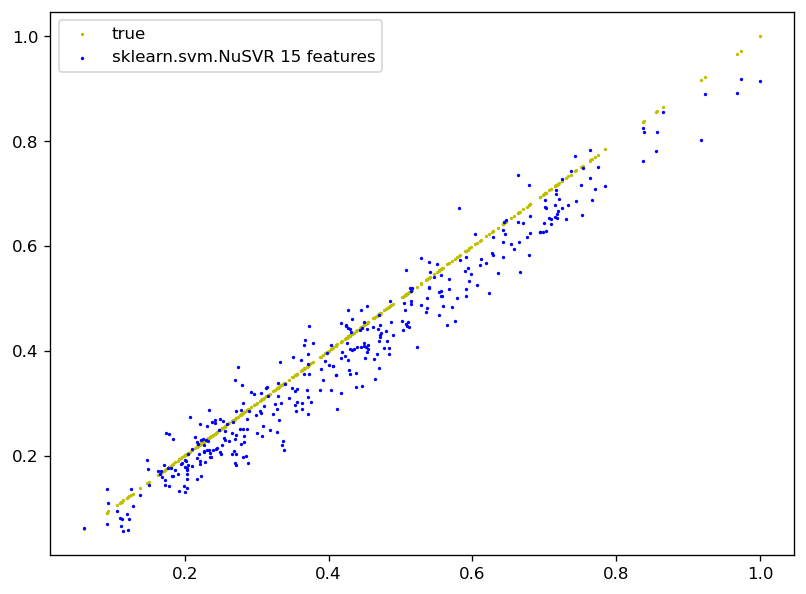

,Algorithm,Explained Variance,R2/COD,Max Error,Mean AE,Mean Squared Error,MAPE,Median AE
7,sklearn.svm.NuSVR 15 features,0.958331,0.936386,0.127133,0.040865,0.002467,0.113059,0.035087


In [27]:
model_desc = 'sklearn.svm.NuSVR ' + str(len(predictors_df.columns)) + ' features'
new_predictors_df = winnow_predictors(predictors_df, target_df['sum_spp_load'])
predictors_df = new_predictors_df
plot_and_report(predictors_df, target_df['sum_spp_load'], report)
report.tail(1)

In [28]:
predictors_df.columns.values

array(['is_Saturday', 'is_Sunday', 'is_holiday',
       'TMIN_AR_FT_SMITH_RGNL_AP', 'TMIN_NE_VALENTINE_MILLER_FLD',
       'TMIN_SD_ABERDEEN', 'TMAX_MT_MILES_CITY_F_WILEY_FLD',
       'TMAX_SD_WATERTOWN_RGNL_AP', 'TAVG_CO_DENVER_INTL_AP',
       'CDD_MO_KANSAS_CITY_INTL_AP', 'CDD_NM_ROSWELL_IND_AIR_PK',
       'CDD_OK_TULSA_INTL_AP', 'CDD_TX_DALLAS_LOVE_FLD',
       'HDD_LA_SHREVEPORT', 'HDD_OK_OKLAHOMA_CITY_WILL_ROGERS_AP'],
      dtype=object)

Starting with 15 features at 2021-11-23 14:20:30.960205
Selecting features with genetic algorithm.
gen	nevals	avg                    	std                    	min                      	max                    
0  	150   	[0.66748786 5.47333333]	[0.24292168 2.48916764]	[-0.28738305  1.        ]	[0.88980004 9.        ]
1  	91    	[-532.56372368    7.28      ]	[2.24715595e+03 1.74401835e+00]	[-1.e+04  2.e+00]        	[ 0.88980004 10.        ]
2  	84    	[-732.55105006    8.15333333]	[2.60704871e+03 1.36008170e+00]	[-1.e+04  4.e+00]        	[ 0.88980004 12.        ]
3  	83    	[-865.88118701    8.38      ]	[2.81370167e+03 1.03711137e+00]	[-1.e+04  5.e+00]        	[ 0.88980004 12.        ]
4  	78    	[-532.51125523    8.56      ]	[2.24716840e+03 8.44432748e-01]	[-1.e+04  4.e+00]        	[ 0.88980004 11.        ]
5  	85    	[-999.21064875    8.86666667]	[3.00026312e+03 6.49786290e-01]	[-1.e+04  7.e+00]        	[ 0.88980004 11.        ]
6  	86    	[-1065.8841418      8.95333333]	[3.08716024e+03

64 	82    	[-332.47319398    8.95333333]  	[1.79521466e+03 4.80786393e-01]	[-1.e+04  7.e+00]        	[ 0.89282577 11.        ]
65 	67    	[-265.79815441    9.01333333]  	[1.61121655e+03 2.57854395e-01]	[-1.e+04  8.e+00]        	[ 0.89282577 11.        ]
66 	90    	[-599.16279761    9.00666667]  	[2.37507993e+03 3.36584148e-01]	[-1.e+04  8.e+00]        	[ 0.89282577 10.        ]
67 	85    	[-465.81786215    8.98      ]  	[2.10942673e+03 3.73630834e-01]	[-1.e+04  7.e+00]        	[ 0.89282577 10.        ]
68 	69    	[-332.47236185    9.        ]  	[1.79521481e+03 3.26598632e-01]	[-1.e+04  7.e+00]        	[ 0.89282577 11.        ]
69 	91    	[-332.47257222    8.96      ]  	[1.79521478e+03 3.44093011e-01]	[-1.e+04  7.e+00]        	[ 0.89282577 10.        ]
70 	85    	[-465.81753099    8.99333333]  	[2.10942681e+03 3.74106343e-01]	[-1.e+04  7.e+00]        	[ 0.89282577 11.        ]
71 	94    	[-332.47154521    8.98666667]  	[1.79521497e+03 3.05213950e-01]	[-1.e+04  7.e+00]        	[ 0.892825

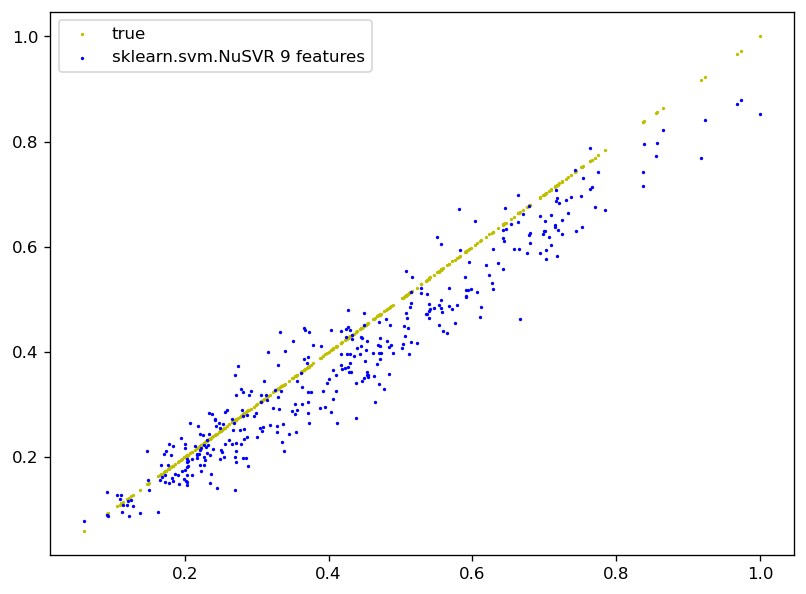

,Algorithm,Explained Variance,R2/COD,Max Error,Mean AE,Mean Squared Error,MAPE,Median AE
8,sklearn.svm.NuSVR 9 features,0.931304,0.894548,0.203498,0.052407,0.004089,0.13348,0.047876


In [29]:
model_desc = 'sklearn.svm.NuSVR ' + str(len(predictors_df.columns)) + ' features'
new_predictors_df = winnow_predictors(predictors_df, target_df['sum_spp_load'])
predictors_df = new_predictors_df
plot_and_report(predictors_df, target_df['sum_spp_load'], report)
report.tail(1)

In [30]:
predictors_df.columns.values

array(['is_Saturday', 'is_Sunday', 'is_holiday',
       'TMAX_MT_MILES_CITY_F_WILEY_FLD', 'CDD_MO_KANSAS_CITY_INTL_AP',
       'CDD_NM_ROSWELL_IND_AIR_PK', 'CDD_OK_TULSA_INTL_AP',
       'HDD_LA_SHREVEPORT', 'HDD_OK_OKLAHOMA_CITY_WILL_ROGERS_AP'],
      dtype=object)

## Display report

In [31]:
report.tail(50)

,Algorithm,Explained Variance,R2/COD,Max Error,Mean AE,Mean Squared Error,MAPE,Median AE
0,sklearn.svm.NuSVR 481 features,0.969399,0.951331,0.155966,0.034574,0.001887,0.096031,0.030218
1,sklearn.svm.NuSVR 204 features,0.968410,0.948868,0.127880,0.035083,0.001983,0.096314,0.029405
2,sklearn.svm.NuSVR 126 features,0.964251,0.948085,0.140659,0.035539,0.002013,0.097616,0.030423
3,sklearn.svm.NuSVR 83 features,0.964790,0.947800,0.139715,0.035646,0.002024,0.098877,0.030003
4,sklearn.svm.NuSVR 54 features,0.964661,0.946521,0.141138,0.036321,0.002074,0.102020,0.030810
5,sklearn.svm.NuSVR 35 features,0.964451,0.940452,0.140284,0.038503,0.002309,0.104472,0.031218
6,sklearn.svm.NuSVR 23 features,0.961158,0.935268,0.137628,0.040570,0.002510,0.111065,0.036628
7,sklearn.svm.NuSVR 15 features,0.958331,0.936386,0.127133,0.040865,0.002467,0.113059,0.035087
8,sklearn.svm.NuSVR 9 features,0.931304,0.894548,0.203498,0.052407,0.004089,0.133480,0.047876


# Run times for 80 generations and N features * 10 individuals

Keeping 66% of features each generation:

* 431 -> 204 features in 9.5 hours
* 204 -> 126 features in 3 hours  ( at the end it takes 3 generations to get 1/10th percent better )
* 126 -> 83 features in 1.5 hours
* 83 -> 54 features in 50 minutes
* 54 -> 35 features in 30 minutes
* 35 -> 23 features in 18 minutes
* 23 -> 15 features in 10 minutes
* 15 -> 9 features in 6 minutes

On an Intel(R) Core(TM) i5-7500 CPU with 4 cores at 3.6 GHz each


## Ideas for improvement: 
* Pre-seed population with high-scoring heros from previous run 
* (done) Let it run all night and see if it can get any better from random mutations
* Modify genetic library to use a minimum number of features instead of 1 as a minimum

## Next I'll use the stations and holidays identified here as relevant in more scikit-learn algorithms.